# Understanding SHAP by fitting more SHAPs!
(using stratified 5-fold cross validation, and a model with 8 features)

## Plain English summary

From the XGBoost model fitted to 0fold data, get a SHAP value for the hospital that the patient attended. What does this hospital SHAP value show? Are there any relationships (reasons) between this value and the valuesof the features for that patient? For example, for this particular hosptial that has a patient with a severe stroke and prior disability, how does this hospital act? 

If fit a XGBoost model of these feature valeus to the hostpial SHAP value, then the SHAP values for hte features show how they contribute to getting the SHAP - help to unpick any relationships between teh feature values and the hostpial SHAP for that patient.

## Model and data

XGBoost models were trained on stratified k-fold cross-validation data. The 8 features in the model are:

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (1 = Yes, 0 = No)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)
* Thrombolysis use: Stroke team attended

And one target feature:
* Mean SHAP values for the hospital one-hot encoded feature that the patient attended, from the 0fold model.

## Aims

* Fit XGBoost model using feature data to predict SHAP value, a model per hospital
* Or a model for the 30 bottom hosptials

## Observations

* SHAP values for the 132 hosptial features range from -2.26 to 2.37.
* Per hospital, the range of the SHAP values are on average 1.13 (with min range being 0, and max range being 2.34)
* Can we predict the hosptial SHAP value from the other feature values (use kfold for these next three models)?:
- Fitting a single model to all 30 hospitals with the lowest thrombolysis rates (for the 10K cohort) gave R-squared of ~0.3
- Fitting to a single hospital gave R-squared of ~0.8.
- Fitting a model to each hospital individually, and collating all of the values for the observed and the predicted when the instance is in the test set (so get a complete set for the instnaces) gave R-squared of 0.951
* 
* Analyse the SHAP of the features. Do this per hosptial, as each hosptial has a different pattern.

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

#from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.linear_model import LinearRegression
from sklearn import metrics

from scipy.stats import linregress
import shap
from imblearn.over_sampling import RandomOverSampler

import json

from matplotlib import colors
from matplotlib import cm

from sklearn.model_selection import StratifiedKFold

## Set modifications to apply

In [2]:
use_minority_oversampling = False

# Set model type (used in file save, e.g. xgb_combined_calibrated_oversampled)
model_type = 'xgb_combined_key_features'

## Create output folders if needed

In [3]:
path = './output'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './predictions'
if not os.path.exists(path):
    os.makedirs(path)

## Load data

Thrombolysis rate on 10K cohort

In [4]:
# Read data and rank on thrombolysis rate
thrombolysis_by_hosp = pd.read_csv(
    './output/10k_thrombolysis_rate_by_hosp_key_features.csv', index_col='stroke_team')

thrombolysis_by_hosp.sort_values(
    'Thrombolysis rate', ascending=False, inplace=True)

SHAP for hosptial feature, with the other 8 features

In [5]:
# Read in thrombolysis rate on 10K cohort
feature_data_with_shap = pd.read_csv(
    './predictions/feature_data_with_hospital_shap.csv')

In [6]:
feature_data_with_shap

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Stroke team,Use of AF anticoagulents,Onset-to-arrival time,Thrombolysis,Hospital_SHAP
0,1.0,0,10.0,1,2,AGNOF1041H,0,190.0,0,0.095683
1,1.0,1,17.0,1,0,AGNOF1041H,0,119.0,1,-0.042648
2,2.0,1,15.0,0,4,AGNOF1041H,0,64.0,0,-0.174697
3,2.0,1,4.0,1,1,AGNOF1041H,0,120.0,0,-0.089601
4,8.0,1,12.0,1,2,AGNOF1041H,0,82.0,1,-0.050211
...,...,...,...,...,...,...,...,...,...,...
17754,34.0,1,10.0,1,2,ZRRCV7012C,0,119.0,0,-0.627209
17755,31.0,1,4.0,0,1,ZRRCV7012C,1,50.0,0,-0.433139
17756,1.0,1,5.0,1,3,ZRRCV7012C,0,73.0,0,-0.228851
17757,58.0,1,16.0,0,2,ZRRCV7012C,0,144.0,0,-0.761119


In [7]:
feature_data_with_shap["Hospital_SHAP"].describe()

count    17759.000000
mean         0.048331
std          0.577870
min         -2.259758
25%         -0.265531
50%          0.002955
75%          0.377608
max          2.379424
Name: Hospital_SHAP, dtype: float64

How do the Hospital_SHAP values range by hospital?

In [8]:
shap_range = (
    feature_data_with_shap.groupby(["Stroke team"])["Hospital_SHAP"].max() - 
    feature_data_with_shap.groupby(["Stroke team"])["Hospital_SHAP"].min())

shap_range.describe()

count    132.000000
mean       1.135384
std        0.466049
min        0.000000
25%        0.796272
50%        1.183356
75%        1.420849
max        2.341264
Name: Hospital_SHAP, dtype: float64

In [9]:
mask = shap_range == 0
hospital_zero_range = shap_range[mask].index

print("Hospitals with a zero range for all of the instances hosptial SHAP value")
print()
for h in hospital_zero_range:
    mask = feature_data_with_shap["Stroke team"] == h
    print(h)
    print(feature_data_with_shap[mask]["Hospital_SHAP"].describe())

Hospitals with a zero range for all of the instances hosptial SHAP value

WSFVN0229E
count    33.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: Hospital_SHAP, dtype: float64


Show violin plot for the 132 hosptials, showing the SHAP values

In [10]:
def set_ax(ax, category_list, feat, rotation=0):
    '''
    ax [matplotlib axis object] = matplotlib axis object
    category_list [list] = used for the xtick labels (the grouping of the data)
    rotation [integer] = xtick label rotation
    feat [string] = used in the axis label, the feature that is being plotted
    
    resource: 
    https://matplotlib.org/3.1.0/gallery/statistics/customized_violin.html
    '''
    # Set the axes ranges and axes labels
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(category_list) + 1))
    ax.set_xticklabels(category_list, rotation=rotation, fontsize=7)
    ax.set_xlim(0.25, len(category_list) + 0.75)
    ax.set_ylabel(f'SHAP values for {feat} [blue violins]', fontsize=12)
    ax.set_xlabel(f'Hospitals (in descending thrombolysis rate)', fontsize=12)
    return(ax)

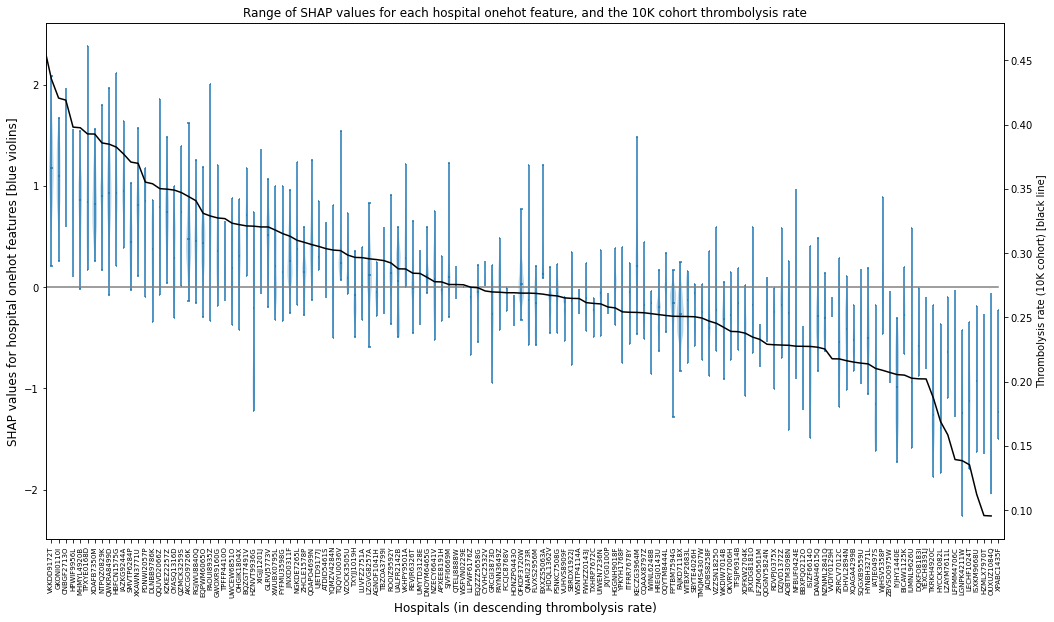

In [11]:
admissions = []
fig = plt.figure(figsize=(15,9))

 # create a list, each entry contains the corresponsing SHAP value for that 
# hosptial. A violin will represent each list (the SHAPS for each hosptial).    
shap_per_category = []
for hospital in thrombolysis_by_hosp.index:
    
    # Extract the data for this single hospital
    mask = feature_data_with_shap["Stroke team"] == hospital
    data = feature_data_with_shap[mask]
    shap_per_category.append(data["Hospital_SHAP"])
    admissions.append(sum(mask))

width = [a/max(admissions) for a in admissions]

# create list of unique categories in the feature data
category_list = thrombolysis_by_hosp.index
#category_list = [int(i) for i in category_list]

# create violin plot
ax = fig.add_subplot()
ax.violinplot(shap_per_category, showmedians=True, widths=width)#0.9)

# Add line at Shap = 0
n_violins = len(thrombolysis_by_hosp.index)
ax.plot([0, n_violins], [0,0],c='0.5')   

# Add thrombolysis rate on second axis
ax2 = ax.twinx()
ax2.plot(thrombolysis_by_hosp["Thrombolysis rate"].values, c="black")
ax2.set_ylabel("Thrombolysis rate (10K cohort) [black line]")

# customise the axes
ax = set_ax(ax, category_list, "hospital onehot features", rotation=90)
plt.subplots_adjust(bottom=0.15, wspace=0.05)

## Adjust stroke severity tickmarks
#if feat == 'Stroke severity':
#    ax.set_xticks(np.arange(0, len(category_list), 2))
#    ax.set_xticklabels(category_list[0::2])   

# Add title
ax.set_title("Range of SHAP values for each hospital onehot feature, and the 10K cohort thrombolysis rate")
    
plt.tight_layout(pad=2)
    
fig.savefig(
f'output/hospital_feature_shap_violin.jpg', dpi=300,
 bbox_inches='tight', pad_inches=0.2)

What is explaining this range of SHAP vlaues for each hospital, why does each patient have a different SHAP value for the hosptial they attend?

(Apart from WSFVN0229E, which has all 33 patients with 0 SHAP).

## Functions

Calculate r squared

In [12]:
def calc_r_squared(y_test, y_pred):
    slope, intercept, r_value, p_value, std_err = linregress(y_test, y_pred)
    r_squared = r_value**2
    return(r_squared)

Plot scatter: observed vs predicted

In [13]:
def plot_observed_predicted(y_test, y_pred, r_squared):#, hospital_list_flatten):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot()
    ax.scatter(y_test, y_pred)#, c=hospital_list_flatten)
    ax.set_xlabel('Observed')
    ax.set_ylabel('Predicted')
    ax.set_title(f'XG-Boost regression of hospital feature SHAP\nR-squared: {r_squared:0.3f}')
    return()

## Fit model
XGBoost models were trained on stratified k-fold cross-validation data.
A model was trained per hosptial.

Report r-squared of observed vs predicted for each instances when in the test set.

In [16]:
# Set up lists
hospital_list = []
observed = []
predicted = []
hospital_instances = []
ivt_rate_10k_list = []

for hospital in thrombolysis_by_hosp.index:
    ivt_rate_10k = thrombolysis_by_hosp.loc[hospital]["Thrombolysis rate"]
    # Extract the data for this single hospital
    mask = feature_data_with_shap["Stroke team"] == hospital
    data = feature_data_with_shap[mask]
    data.drop(["Stroke team"], axis=1, inplace=True)
    n_instances = sum(mask)
    hospital_instances.append(n_instances)

    # Initialise empty lists
    train_data, test_data = [], []

    # Set up splits
    number_of_splits = 5
    skf = StratifiedKFold(n_splits = number_of_splits, shuffle=True, random_state=13)
    strat = data['Thrombolysis'].map(str)# + '-' + data['Hospital_SHAP'].map(str)
    # ValueError: n_splits=5 cannot be greater than the number of members in each class.

    skf.get_n_splits(data, strat.values)

    # Put in NumPy arrays
    X = data.values
    y = strat.values
    X_col_names = list(data)

    # Loop through the k-fold splits
    counter = 0
    for train_index, test_index in skf.split(X, y):  

        # Get Xtrain and test
        train_np, test_np = X[train_index], X[test_index]
        
        # Convert to Pandas DataFrames
        train = pd.DataFrame(train_np, columns=X_col_names)
        test = pd.DataFrame(test_np, columns=X_col_names)

        # Get X and y
        X_train = train.drop("Hospital_SHAP", axis=1)
        X_test = test.drop("Hospital_SHAP", axis=1)
        y_train = train["Hospital_SHAP"]
        y_test = test["Hospital_SHAP"]

        # Define model
        model = XGBRegressor()
        
        # Fit model
        model.fit(X_train, y_train)

        # Get predicted probabilities
        y_pred = model.predict(X_test)
    
        # Store the test values: observed and predicted
        # Each instance will be stored as a predicted value when in the test set
        observed.append(y_test)
        predicted.append(y_pred)
        counter += 1
    hospital_list.append([hospital] * n_instances)
    ivt_rate_10k_list.append([ivt_rate_10k] * n_instances)

# Print performance (r-squared)
observed_flatten = [x for xs in observed for x in xs]
predicted_flatten = [x for xs in predicted for x in xs]
hospital_list_flatten = [x for xs in hospital_list for x in xs]
ivt_rate_10k_list_flatten = [x for xs in ivt_rate_10k_list for x in xs]

r_squared = calc_r_squared(observed_flatten, predicted_flatten)
print (
    f'All kfolds for all hospitals. R-squared: {r_squared:0.3f}')

All kfolds for all hospitals. R-squared: 0.951


In [17]:
def plot_observed_predicted(y_test, y_pred, r_squared):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot()
    ax.scatter(y_test, y_pred)
    ax.set_xlabel('Observed')
    ax.set_ylabel('Predicted')
    ax.set_title(f'XG-Boost regression of hospital feature SHAP\nR-squared: {r_squared:0.3f}')
    return()

()

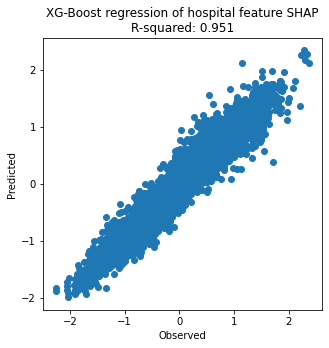

In [18]:
plot_observed_predicted(observed_flatten, predicted_flatten, r_squared)#, colour_list)

Show this plot again, with more information. For example, which are the same hosptials, and what are their thrombolysis rates?

For a function to return list of n colours to be passed to the plot making code, look at code from http://localhost:8891/lab/tree/01_compare_10k_cohort_models.ipynb

In [19]:
def plot_observed_predicted_colour(y_test, y_pred, r_squared, ivt_rate):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot()
    scatter = ax.scatter(y_test, y_pred, c=ivt_rate, cmap="viridis", s=1)
    ax.set_xlabel('Observed SHAP hostpial one-hot feature')
    ax.set_ylabel('Predicted SHAP hostpial one-hot feature')
    ax.grid()
    ax.set_title(f'XG-Boost regression of hospital feature SHAP\nR-squared: '
                 f'{r_squared:0.3f} \nPoints coloured by 10K cohort IVT rate')
    fig.colorbar(scatter)
    return()

()

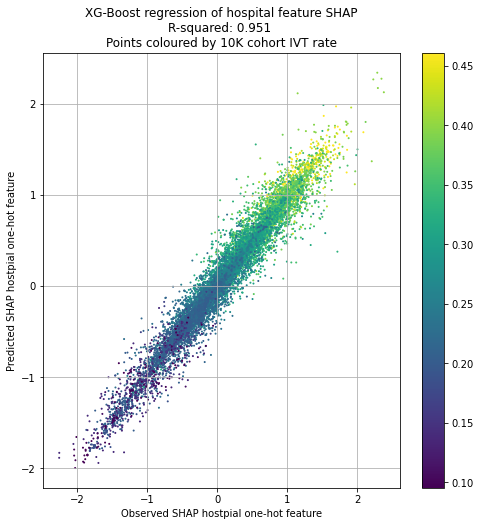

In [20]:
plot_observed_predicted_colour(observed_flatten, 
                               predicted_flatten, 
                               r_squared, 
                               ivt_rate_10k_list_flatten)

### Histogram of number of instances per hospital

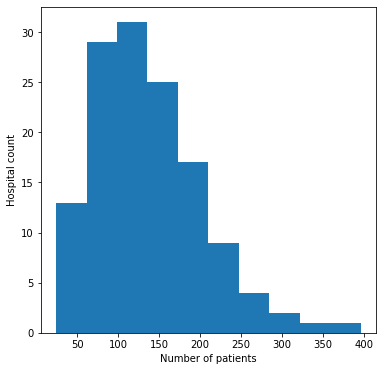

In [21]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.hist(hospital_instances)#, bins=np.arange(0.10, 0.46, 0.025))
ax.set_xlabel('Number of patients')
ax.set_ylabel('Hospital count')
plt.show()

## Fit model (remove IVT feature)


XGBoost models were trained on stratified k-fold cross-validation data.
A model was trained per hosptial.

Report r-squared of observed vs predicted for each instances when in the test set.

Remove thrombolysis feature

In [22]:
# Set up lists
hospital_list = []
observed = []
predicted = []
hospital_instances = []
ivt_rate_10k_list = []

for hospital in thrombolysis_by_hosp.index:
    ivt_rate_10k = thrombolysis_by_hosp.loc[hospital]["Thrombolysis rate"]
    # Extract the data for this single hospital
    mask = feature_data_with_shap["Stroke team"] == hospital
    data = feature_data_with_shap[mask]
    data.drop(["Stroke team"], axis=1, inplace=True)
    n_instances = sum(mask)
    hospital_instances.append(n_instances)

    # Initialise empty lists
    train_data, test_data = [], []

    # Set up splits
    number_of_splits = 5
    skf = StratifiedKFold(n_splits = number_of_splits, shuffle=True, random_state=13)
    strat = data['Thrombolysis'].map(str)# + '-' + data['Hospital_SHAP'].map(str)
    # ValueError: n_splits=5 cannot be greater than the number of members in each class.

    skf.get_n_splits(data, strat.values)

    data.drop(["Thrombolysis"], axis=1, inplace=True)
    
    # Put in NumPy arrays
    X = data.values
    y = strat.values
    X_col_names = list(data)

    # Loop through the k-fold splits
    counter = 0
    for train_index, test_index in skf.split(X, y):  

        # Get Xtrain and test
        train_np, test_np = X[train_index], X[test_index]
        
        # Convert to Pandas DataFrames
        train = pd.DataFrame(train_np, columns=X_col_names)
        test = pd.DataFrame(test_np, columns=X_col_names)

        # Get X and y
        X_train = train.drop("Hospital_SHAP", axis=1)
        X_test = test.drop("Hospital_SHAP", axis=1)
        y_train = train["Hospital_SHAP"]
        y_test = test["Hospital_SHAP"]

        # Define model
        model = XGBRegressor()
        
        # Fit model
        model.fit(X_train, y_train)

        # Get predicted probabilities
        y_pred = model.predict(X_test)
    
        # Store the test values: observed and predicted
        # Each instance will be stored as a predicted value when in the test set
        observed.append(y_test)
        predicted.append(y_pred)
        counter += 1
    hospital_list.append([hospital] * n_instances)
    ivt_rate_10k_list.append([ivt_rate_10k] * n_instances)

# Print performance (r-squared)
observed_flatten = [x for xs in observed for x in xs]
predicted_flatten = [x for xs in predicted for x in xs]
hospital_list_flatten = [x for xs in hospital_list for x in xs]
ivt_rate_10k_list_flatten = [x for xs in ivt_rate_10k_list for x in xs]

r_squared = calc_r_squared(observed_flatten, predicted_flatten)
print (
    f'All kfolds for all hospitals. R-squared: {r_squared:0.3f}')

All kfolds for all hospitals. R-squared: 0.952


()

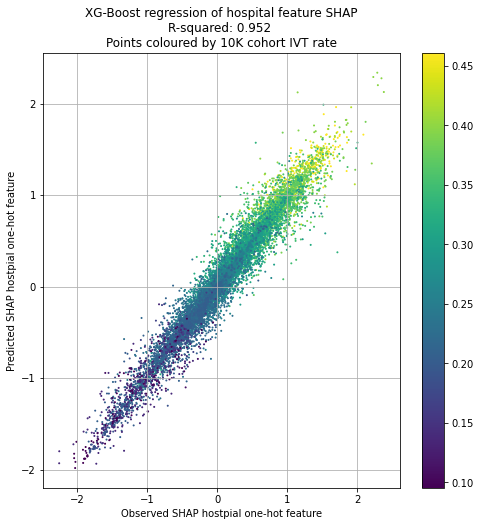

In [23]:
plot_observed_predicted_colour(observed_flatten, 
                               predicted_flatten, 
                               r_squared, 
                               ivt_rate_10k_list_flatten)

# SHAP values

In the above work (using stratified k-fold splits) we have shown that the principle of fitting an XGBoost regressor model to predict the hospital SHAP value, with an R-squared of 0.951 (that is, the predicted value is capturing over 95% or the variance of the observed values).

We will now fit a model per hospital on the full dataset (not hold any back as a test set).

Then we will calculate SHAP values for each feature for ecah instance. 

For the top and bottom 16 (or 9) hospitals, Create shapscatter plot for NIHSS (later violin plots).


How can we explain this work eekekeekek?!

In [31]:
# Set up list to store models and calibarion threshold
models = []
hospital_list = []
# Set up lists for observed and predicted
observed = []
predicted = []
hospital_instances = []
#model_description = []
shap_values_extended_list = []
shap_values_list = []
ivt_rate_10k_list = []
#shap_df = pd.DataFrame()

sum_instances = 0

for hospital in thrombolysis_by_hosp.index:
    ivt_rate_10k = thrombolysis_by_hosp.loc[hospital]["Thrombolysis rate"]
    # Extract the data for this single hospital
    mask = feature_data_with_shap["Stroke team"] == hospital
    data = feature_data_with_shap[mask]
    data.drop(["Stroke team"], axis=1, inplace=True)
#    data.drop(["Thrombolysis"], axis=1, inplace=True)
    n_instances = sum(mask)
    sum_instances += n_instances
    hospital_instances.append(n_instances)

    # Get X and y
    X_train = data.drop("Hospital_SHAP", axis=1)
    y_train = data["Hospital_SHAP"]

    # Define model
    model = XGBRegressor()
        
    #    # Define model
    #    model = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)

        # Fit model
    model.fit(X_train, y_train)
    models.append(model)
#    model_description.append(hospital + "_" + str(counter))
        # Get predicted probabilities
    y_pred = model.predict(X_train)
    
    # Store the train values: observed and predicted
    observed.append(y_train)
    predicted.append(y_pred)
    hospital_list.append([hospital] * n_instances)
    ivt_rate_10k_list.append([ivt_rate_10k] * n_instances)

    # Set up explainer using the model and feature values from training set
    explainer = shap.TreeExplainer(model, X_train)

    # Get (and store) Shapley values along with base and feature values
    shap_values_extended = explainer(X_train)
    shap_values_extended_list.append(shap_values_extended)
    # Shap values exist for each classification in a Tree
    # We are interested in 1=give thrombolysis (not 0=not give thrombolysis)
    shap_values = shap_values_extended.values
    shap_values_list.append(shap_values)     
        
# Print performance (r-squared)
observed_flatten = [x for xs in observed for x in xs]
predicted_flatten = [x for xs in predicted for x in xs]
hospital_list_flatten = [x for xs in hospital_list for x in xs]
ivt_rate_10k_list_flatten = [x for xs in ivt_rate_10k_list for x in xs]

r_squared = calc_r_squared(observed_flatten, predicted_flatten)
print (
    f'All kfolds for all hospitals. R-squared: {r_squared:0.3f}')
print(sum_instances)

All kfolds for all hospitals. R-squared: 1.000
17759


()

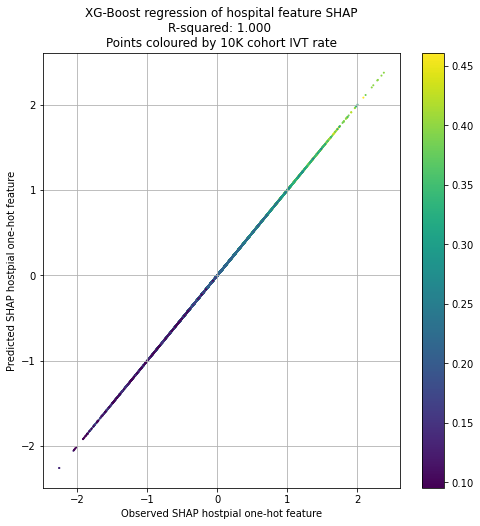

In [32]:
plot_observed_predicted_colour(observed_flatten, 
                               predicted_flatten, 
                               r_squared, 
                               ivt_rate_10k_list_flatten)

## Identify 9 hospitals with lowest thrombolysis rate on 10K patient cohort

In [33]:
top_9_hosp = list(thrombolysis_by_hosp.head(9).index)
bottom_9_hosp = list(thrombolysis_by_hosp.tail(9).index)

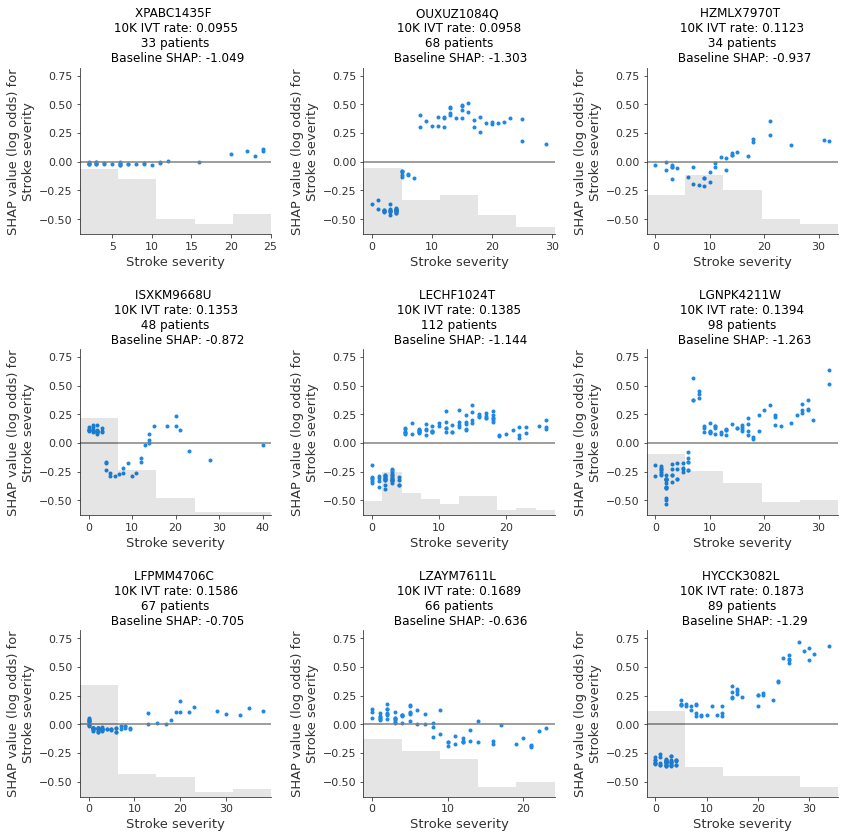

In [48]:
feat = "Stroke severity"

bottom_9_hosp_reversed = list(reversed(bottom_9_hosp))
# Get shap min and max (to put all charts on same scale)
shap_min = 999
shap_max = -999
for hosp in bottom_9_hosp_reversed:    
    #location of h in thrombolysis_by_hosp.index
    mylist = list(thrombolysis_by_hosp.index)
    location = mylist.index(hosp)
    shap_values_extended = shap_values_extended_list[location]
    shap_min = min(shap_min,shap_values_extended.values.min())
    shap_max = max(shap_max,shap_values_extended.values.max())

fig = plt.figure(figsize=(12,12))
for n, hosp in enumerate(bottom_9_hosp_reversed):    
    ax = fig.add_subplot(3,3,n+1)
    
    #location of h in thrombolysis_by_hosp.index
    mylist = list(thrombolysis_by_hosp.index)
    location = mylist.index(hosp)
    shap_values_extended = shap_values_extended_list[location]
    
    shap.plots.scatter(shap_values_extended[:, feat], x_jitter=0, ax=ax, 
                       show=False)
    
    # Add line at Shap = 0
    feature_values = shap_values_extended[:, feat].data
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0,0], c='0.5')    
    
    ax.set_ylabel(f'SHAP value (log odds) for\n{feat}')

    n_instances = shap_values_extended.values.shape[0]
    ivt_rate_10k = thrombolysis_by_hosp.loc[hosp]["Thrombolysis rate"]
    basevalue = shap_values_extended.base_values[0]
    ax.set_title(f"{hosp} \n 10K IVT rate: {ivt_rate_10k} \n {n_instances} "
                 f"patients \n Baseline SHAP: {round(basevalue, 3)}")
    
    # Set ylims
    ax.set_ylim(shap_min - 0.1, shap_max + 0.1)
    
    # Censor arrival to scan to 1200 minutes
    if feat == 'Arrival-to-scan time':
        ax.set_xlim(0,1200)
    
plt.tight_layout(pad=2)

fig.savefig('output/xgb_low_thrombolysis_shap_of_shap_scatter.jpg', dpi=300,
    bbox_inches='tight', pad_inches=0.2)

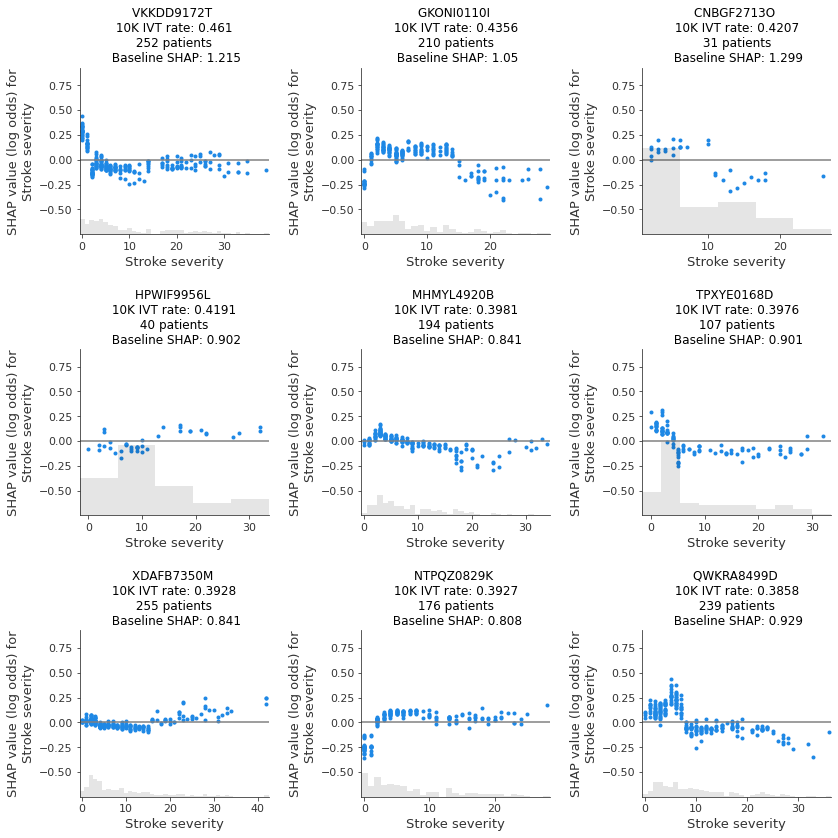

In [49]:
feat = "Stroke severity"

# Get shap min and max (to put all charts on same scale)
shap_min = 999
shap_max = -999
for hosp in top_9_hosp:    
    #location of h in thrombolysis_by_hosp.index
    mylist = list(thrombolysis_by_hosp.index)
    location = mylist.index(hosp)
    shap_values_extended = shap_values_extended_list[location]
    shap_min = min(shap_min,shap_values_extended.values.min())
    shap_max = max(shap_max,shap_values_extended.values.max())
    
fig = plt.figure(figsize=(12,12))
for n, hosp in enumerate(top_9_hosp):    
    ax = fig.add_subplot(3,3,n+1)
    
    #location of h in thrombolysis_by_hosp.index
    mylist = list(thrombolysis_by_hosp.index)
    location = mylist.index(hosp)
    shap_values_extended = shap_values_extended_list[location]
    
    shap.plots.scatter(shap_values_extended[:, feat], x_jitter=0, ax=ax, 
                       show=False)
    
    # Add line at Shap = 0
    feature_values = shap_values_extended[:, feat].data
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0,0], c='0.5')    
    
    # Set ylims
    ax.set_ylim(shap_min - 0.1, shap_max + 0.1)

    ax.set_ylabel(f'SHAP value (log odds) for\n{feat}')

    n_instances = shap_values_extended.values.shape[0]
    ivt_rate_10k = thrombolysis_by_hosp.loc[hosp]["Thrombolysis rate"]
    basevalue = shap_values_extended.base_values[0]
    ax.set_title(f"{hosp} \n 10K IVT rate: {ivt_rate_10k} \n {n_instances} "
                 f"patients \n Baseline SHAP: {round(basevalue, 3)}")

    # Censor arrival to scan to 1200 minutes
    if feat == 'Arrival-to-scan time':
        ax.set_xlim(0,1200)
    
plt.tight_layout(pad=2)

fig.savefig('output/xgb_high_thrombolysis_shap_of_shap_scatter.jpg', dpi=300,
    bbox_inches='tight', pad_inches=0.2)

17759


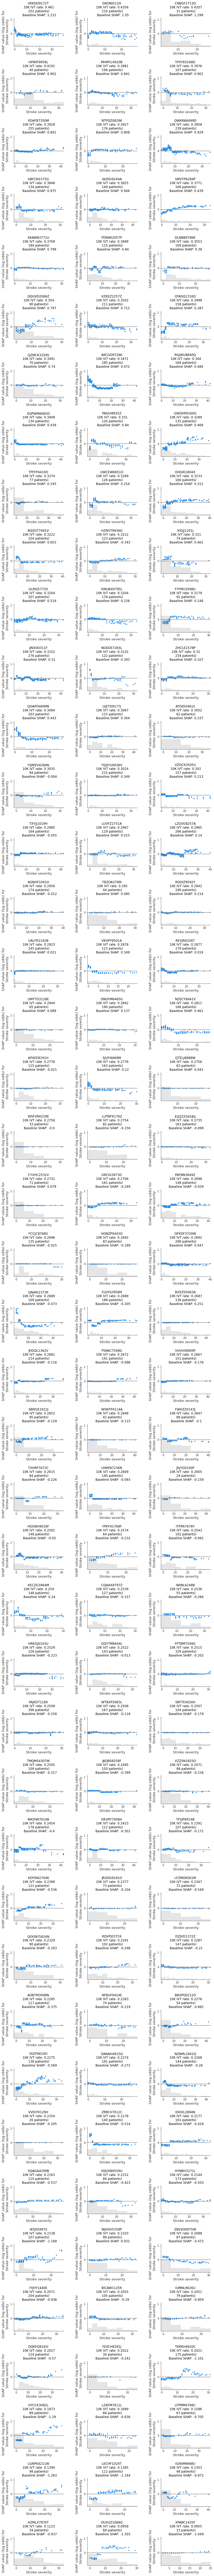

In [36]:
feat = "Stroke severity"

# Get shap min and max (to put all charts on same scale)
shap_min = 999
shap_max = -999
for hosp in list(thrombolysis_by_hosp.index):    
    #location of h in thrombolysis_by_hosp.index
    mylist = list(thrombolysis_by_hosp.index)
    location = mylist.index(hosp)
    shap_values_extended = shap_values_extended_list[location]
    shap_min = min(shap_min,shap_values_extended.values.min())
    shap_max = max(shap_max,shap_values_extended.values.max())

# check it adds up to 17759 instances
sum_instances = 0
fig = plt.figure(figsize=(12,140))
for n, hosp in enumerate(list(thrombolysis_by_hosp.index)):    
    ax = fig.add_subplot(int((132/3)+1),3,n+1)
    
    #location of h in thrombolysis_by_hosp.index
    mylist = list(thrombolysis_by_hosp.index)
    location = mylist.index(hosp)
    shap_values_extended = shap_values_extended_list[location]
    
    shap.plots.scatter(shap_values_extended[:, feat], x_jitter=0, ax=ax, 
                       show=False)
    
    # Add line at Shap = 0
    feature_values = shap_values_extended[:, feat].data
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0,0], c='0.5')    
    
    # Set ylims
    ax.set_ylim(shap_min - 0.1, shap_max + 0.1)

    ax.set_ylabel(f'SHAP value (log odds) for\n{feat}')

    n_instances = shap_values_extended.values.shape[0]
    # check it adds up to 17759 instances
    sum_instances += n_instances
    
    ivt_rate_10k = thrombolysis_by_hosp.loc[hosp]["Thrombolysis rate"]
    basevalue = shap_values_extended.base_values[0]
    ax.set_title(f"{hosp} \n 10K IVT rate: {ivt_rate_10k} \n {n_instances} "
                 f"patients \n Baseline SHAP: {round(basevalue, 3)}")

    # Censor arrival to scan to 1200 minutes
    if feat == 'Arrival-to-scan time':
        ax.set_xlim(0,1200)
    
plt.tight_layout(pad=2)

fig.savefig('output/xgb_shap_of_shap_scatter.jpg', dpi=300,
    bbox_inches='tight', pad_inches=0.2)

# check it adds up to 17759 instances
print (sum_instances)

# Add base value to the SHAP value
For plotting purposes

In [37]:
import copy
shap_values_extended = copy.deepcopy(shap_values_extended_list[0])
feat = "Stroke severity"
shap_values_extended[:, feat]

.values =
array([ 2.93091714e-01,  1.41626969e-01,  4.41704702e-01,  4.91008433e-02,
       -4.42884269e-02,  1.94141179e-01, -1.12493812e-02, -1.21405527e-02,
       -7.01810323e-02, -1.81550835e-01, -3.09514188e-02, -2.31950847e-01,
        3.38307780e-01, -1.04432336e-01, -7.46798200e-02, -6.32738588e-02,
       -1.24873585e-01, -8.46240895e-02, -8.62434070e-02,  9.61413342e-02,
       -3.26879252e-02, -1.22816748e-01,  1.68651932e-01, -7.62704428e-03,
       -1.40992687e-04, -1.74416125e-02, -5.33455209e-02, -1.44119359e-01,
       -6.09444363e-02, -1.00431321e-01, -1.19567499e-01,  5.68635303e-02,
       -7.47388245e-02, -7.86750507e-02, -7.39929173e-02,  1.99623599e-01,
        6.13684622e-03, -3.90748917e-02, -5.45070163e-02,  2.14282966e-01,
       -1.32441080e-01, -7.06942092e-02, -3.17736587e-02, -1.07489006e-01,
        1.61984915e-01,  7.25861633e-02, -5.89761991e-02, -5.27256403e-02,
        7.30837715e-02, -8.03627780e-02, -1.66523714e-01, -7.04187239e-02,
       -5.78600

In [38]:
shap_values_extended[:, feat].values += shap_values_extended[:, feat].base_values
shap_values_extended[:, feat].values

array([1.50844354, 1.3569788 , 1.65705653, 1.26445267, 1.1710634 ,
       1.40949301, 1.20410245, 1.20321128, 1.1451708 , 1.033801  ,
       1.18440041, 0.98340098, 1.55365961, 1.11091949, 1.14067201,
       1.15207797, 1.09047825, 1.13072774, 1.12910842, 1.31149317,
       1.18266391, 1.09253508, 1.38400376, 1.20772479, 1.21521084,
       1.19791022, 1.16200631, 1.07123247, 1.15440739, 1.11492051,
       1.09578433, 1.27221536, 1.14061301, 1.13667678, 1.14135891,
       1.41497543, 1.22148868, 1.17627694, 1.16084481, 1.4296348 ,
       1.08291075, 1.14465762, 1.18357817, 1.10786283, 1.37733675,
       1.28793799, 1.15637563, 1.16262619, 1.2884356 , 1.13498905,
       1.04882812, 1.14493311, 1.15749176, 1.54706144, 1.36859546,
       1.08392354, 1.21562023, 1.16432143, 1.1485574 , 1.15406981,
       1.11622607, 1.13515269, 1.08072606, 1.14519021, 1.12939595,
       1.18087939, 1.06693353, 1.55073399, 1.19776396, 1.13120296,
       1.07843643, 1.35381488, 1.25415398, 1.38831358, 1.17383

# Extra cells
1) Fit model on 30 bottom hosptials
2) Fit model on 1 hosptial

## Fit model on one hospital

XGBoost models were trained on stratified k-fold cross-validation data.

Report r-squared of observed vs predicted.

In [39]:
# Set up list to store models and calibarion threshold
models = []

# Set up lists for observed and predicted
observed = []
predicted = []

# Set up list for feature importances
feature_importance = []

# Loop through k folds
for k_fold in range(5):
    
    # Get k fold split
    train = train_data[k_fold]
    test = test_data[k_fold]
    
    # Get X and y
    X_train = train.drop("Hospital_SHAP", axis=1)
    X_test = test.drop("Hospital_SHAP", axis=1)
    y_train = train["Hospital_SHAP"]
    y_test = test["Hospital_SHAP"]
    
#    # Use oversampling if required
#    if use_minority_oversampling:
#        oversample = RandomOverSampler(sampling_strategy='minority')
#        X_train, y_train = oversample.fit_resample(X_train, y_train)        
    
#    # One hot encode hospitals
#    X_train_hosp = pd.get_dummies(X_train['Stroke team'], prefix = 'team')
#    X_train = pd.concat([X_train, X_train_hosp], axis=1)
#    X_train.drop('Stroke team', axis=1, inplace=True)
#    X_test_hosp = pd.get_dummies(X_test['Stroke team'], prefix = 'team')
#    X_test = pd.concat([X_test, X_test_hosp], axis=1)
#    X_test.drop('Stroke team', axis=1, inplace=True)    
    
    # Define model
    model = XGBRegressor()
#    # Define model
#    model = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)
    
    # Fit model
    model.fit(X_train, y_train)
    models.append(model)
    
    # Get predicted probabilities
    y_pred = model.predict(X_test)
#    y_probs = model.predict_proba(X_test)[:,1]
    observed.append(y_test)
    predicted.append(y_pred)
    
#    # Get feature importances
#    importance = model.feature_importances_
#    feature_importance.append(importance)
    
    # Print performance (r-squared)
    r_squared = calc_r_squared(y_test, y_pred)
    print (
        f'Run {k_fold}, R-squared: {r_squared:0.3f}')

    # Plot XGBoost regression of SHAP
    plot_observed_predicted(y_test, y_pred, r_squared)

IndexError: list index out of range

In [ ]:
# Set up list to store models and calibarion threshold
models = []

# Set up lists for observed and predicted
observed = []
predicted = []
hospital_instances = []

for hospital in thrombolysis_by_hosp.index:

    # Extract the data for this single hospital
    mask = feature_data_with_shap["Stroke team"] == hospital
    data = feature_data_with_shap[mask]
    data.drop(["Stroke team"], axis=1, inplace=True)
    hospital_instances.append(data.shape[0])
#    print(f"Hospital {hospital} has {data.shape[0]} instances")
    

    # Set up list for feature importances
#    feature_importance = []

    # Initialise empty lists
    train_data, test_data = [], []

    # Set up splits
    number_of_splits = 5
    skf = StratifiedKFold(n_splits = number_of_splits, shuffle=True, random_state=13)
    strat = data['Thrombolysis'].map(str)
    skf.get_n_splits(data, strat.values)

    # Put in NumPy arrays
    X = data.values
    y = strat.values
    X_col_names = list(data)

    # Loop through the k-fold splits
    counter = 0
    for train_index, test_index in skf.split(X, y):  

        # Get Xtrain and test
        train_np, test_np = X[train_index], X[test_index]

        # Convert to Pandas DataFrames
        train = pd.DataFrame(train_np, columns=X_col_names)
        test = pd.DataFrame(test_np, columns=X_col_names)

        counter += 1

        # Get X and y
        X_train = train.drop("Hospital_SHAP", axis=1)
        X_test = test.drop("Hospital_SHAP", axis=1)
        y_train = train["Hospital_SHAP"]
        y_test = test["Hospital_SHAP"]

    #    # Use oversampling if required
    #    if use_minority_oversampling:
    #        oversample = RandomOverSampler(sampling_strategy='minority')
    #        X_train, y_train = oversample.fit_resample(X_train, y_train)        

    #    # One hot encode hospitals
    #    X_train_hosp = pd.get_dummies(X_train['Stroke team'], prefix = 'team')
    #    X_train = pd.concat([X_train, X_train_hosp], axis=1)
    #    X_train.drop('Stroke team', axis=1, inplace=True)
    #    X_test_hosp = pd.get_dummies(X_test['Stroke team'], prefix = 'team')
    #    X_test = pd.concat([X_test, X_test_hosp], axis=1)
    #    X_test.drop('Stroke team', axis=1, inplace=True)    

        # Define model
        model = XGBRegressor()
    #    # Define model
    #    model = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)

        # Fit model
        model.fit(X_train, y_train)
        models.append(model)

        # Get predicted probabilities
        y_pred = model.predict(X_test)
    #    y_probs = model.predict_proba(X_test)[:,1]
    
        # Store the test values: observed and predicted
        # Means each instance will be stored as a predicted value when in the 
        # test set
        observed.append(y_test)
        predicted.append(y_pred)

    #    # Get feature importances
    #    importance = model.feature_importances_
    #    feature_importance.append(importance)

# Print performance (r-squared)

observed_flatten = [x for xs in observed for x in xs]
predicted_flatten = [x for xs in predicted for x in xs]
r_squared = calc_r_squared(observed_flatten, predicted_flatten)
print (
    f'All kfolds for all hospitals. R-squared: {r_squared:0.3f}')

# Plot XGBoost regression of SHAP
plot_observed_predicted(observed_flatten, predicted_flatten, r_squared)

In [ ]:
# Histogram of number of instances per hospital
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.hist(hospital_instances)#, bins=np.arange(0.10, 0.46, 0.025))
ax.set_xlabel('Number of patients')
ax.set_ylabel('Hospital count')
plt.show()

# KP STOP HERE. REGROUP!

### Collate and save results 

In [ ]:
hospital_results = []
kfold_result = []
observed_results = []
prob_results = []
predicted_results = []

for i in range(5):
    hospital_results.extend(list(test_data[i]['Stroke team']))
    kfold_result.extend(list(np.repeat(i, len(test_data[i]))))
    observed_results.extend(list(observed[i]))
    prob_results.extend(list(predicted_proba[i]))
    predicted_results.extend(list(predicted[i]))    
    
model_predictions = pd.DataFrame()
model_predictions['hospital'] = hospital_results
model_predictions['observed'] = np.array(observed_results) * 1.0
model_predictions['prob'] = prob_results
model_predictions['predicted'] = predicted_results
model_predictions['k_fold'] = kfold_result
model_predictions['correct'] = model_predictions['observed'] == model_predictions['predicted']

# Save
filename = f'./predictions/{model_type}_predictions.csv'
model_predictions.to_csv(filename, index=False)

# Save combined test set
combined_test_set = pd.concat(test_data, axis=0)
combined_test_set.reset_index(inplace=True); del combined_test_set['index']
combined_test_set.to_csv(f'./predictions/{model_type}_combined_test_features.csv')

## Compare predicted and actual thrombolysis rates

In [ ]:
mean_results_by_hosp  = model_predictions.groupby('hospital').mean()

Get r-square of predicted thrombolysis rate.

In [ ]:
x_comparision = np.array(mean_results_by_hosp['observed']).reshape(-1, 1)
y_comparision = np.array(mean_results_by_hosp['predicted']).reshape(-1, 1)

slr = LinearRegression()
slr.fit(x_comparision, y_comparision)
y_pred = slr.predict(x_comparision)
r_square = metrics.r2_score(y_comparision, y_pred)

print(f'R squared {r_square:0.3f}')

In [ ]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.scatter(x_comparision,
            y_comparision)

plt.plot (x_comparision, slr.predict(x_comparision), color = 'red')
text = f'R squared: {r_square:.3f}'
ax1.text(0.33,0.13, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
ax1.set_xlabel('Observed thrombolysis use (%)')
ax1.set_ylabel('Predicted thrombolysis use (%)')
plt.grid()
plt.savefig(f'output/{model_type}_observed_predicted_rates.jpg', dpi=300)
plt.show()

## Feature Importances

Get XGBoost feature importances (average across k-fold results)

In [ ]:
# Feature names
features = X_test.columns.values

# Get average feature importance from k-fold
importances = np.array(feature_importance).mean(axis = 0)
feature_importance = pd.DataFrame(data = importances, index=features)
feature_importance.columns = ['importance']

# Sort by importance (weight)
feature_importance.sort_values(by='importance', ascending=False, inplace=True)

# Save
feature_importance.to_csv(f'output/{model_type}_feature_importance.csv')

# Display top 25
feature_importance.head(25)

Create a bar chart for the XGBoost feature importance values

In [ ]:
# Set up figure
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

# Get labels and values
labels = feature_importance.index.values[0:25]
pos = np.arange(len(labels))
val = feature_importance['importance'].values[0:25]

# Plot
ax.bar(pos, val)
ax.set_ylabel('Feature importance')
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

plt.tight_layout()
plt.savefig(f'output/{model_type}_feature_weights_bar.jpg', dpi=300)
plt.show()

## Calibration and assessment of accuracy when model has high confidence

In [ ]:
# Collate results in Dataframe
reliability_collated = pd.DataFrame()

# Loop through k fold predictions
for i in range(5):
    
    # Get observed class and predicted probability
    obs = observed[i]
    prob = predicted_proba[i]
    
    # Bin data with numpy digitize (this will assign a bin to each case)
    step = 0.10
    bins = np.arange(step, 1+step, step)
    digitized = np.digitize(prob, bins)
        
    # Put single fold data in DataFrame
    reliability = pd.DataFrame()
    reliability['bin'] = digitized
    reliability['probability'] = prob
    reliability['observed'] = obs
    classification = 1 * (prob > 0.5 )
    reliability['correct'] = obs == classification
    reliability['count'] = 1
    
    # Summarise data by bin in new dataframe
    reliability_summary = pd.DataFrame()

    # Add bins and k-fold to summary
    reliability_summary['bin'] = bins
    reliability_summary['k-fold'] = i

    # Calculate mean of predicted probability of thrombolysis in each bin
    reliability_summary['confidence'] = \
        reliability.groupby('bin').mean()['probability']

    # Calculate the proportion of patients who receive thrombolysis
    reliability_summary['fraction_positive'] = \
        reliability.groupby('bin').mean()['observed']
    
    # Calculate proportion correct in each bin
    reliability_summary['fraction_correct'] = \
        reliability.groupby('bin').mean()['correct']
    
    # Calculate fraction of results in each bin
    reliability_summary['fraction_results'] = \
        reliability.groupby('bin').sum()['count'] / reliability.shape[0]   
    
    # Add k-fold results to DatafRame collation
    reliability_collated = reliability_collated.append(reliability_summary)
    
# Get mean results
reliability_summary = reliability_collated.groupby('bin').mean()
reliability_summary.drop('k-fold', axis=1, inplace=True)

In [ ]:
reliability_summary

Plot results:

In [ ]:
fig = plt.figure(figsize=(10,5))

# Plot predicted prob vs fraction psotive
ax1 = fig.add_subplot(1,2,1)

# Loop through k-fold reliability results
for i in range(5):
    mask = reliability_collated['k-fold'] == i
    k_fold_result = reliability_collated[mask]
    x = k_fold_result['confidence']
    y = k_fold_result['fraction_positive']
    ax1.plot(x,y, color='orange')
# Add 1:1 line
ax1.plot([0,1],[0,1], color='k', linestyle ='--')
# Refine plot
ax1.set_xlabel('Model probability')
ax1.set_ylabel('Fraction positive')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)

# Plot accuracy vs probability
ax2 = fig.add_subplot(1,2,2)
# Loop through k-fold reliability results
for i in range(5):
    mask = reliability_collated['k-fold'] == i
    k_fold_result = reliability_collated[mask]
    x = k_fold_result['confidence']
    y = k_fold_result['fraction_correct']
    ax2.plot(x,y, color='orange')
# Refine plot
ax2.set_xlabel('Model probability')
ax2.set_ylabel('Fraction correct')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)

# instantiate a second axes that shares the same x-axis
ax3 = ax2.twinx()  
for i in range(5):
    mask = reliability_collated['k-fold'] == i
    k_fold_result = reliability_collated[mask]
    x = k_fold_result['confidence']
    y = k_fold_result['fraction_results']
    ax3.plot(x,y, color='blue')
    
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 0.5)
ax3.set_ylabel('Fraction of samples')

custom_lines = [Line2D([0], [0], color='orange', alpha=0.6, lw=2),
                Line2D([0], [0], color='blue', alpha = 0.6,lw=2)]

ax1.grid()
ax2.grid()

plt.legend(custom_lines, ['Fraction correct', 'Fraction of samples'],
          loc='upper center')

plt.tight_layout(pad=2)

plt.savefig(f'./output/{model_type}_reliability.jpg', dpi=300)
plt.show()

Get accuracy of model when model is at least 80% confident

In [ ]:
bins = [0.1, 0.2, 0.9, 1.0]
acc = reliability_summary.loc[bins].mean()['fraction_correct']
frac = reliability_summary.loc[bins].sum()['fraction_results']

print ('For samples with at least 80% confidence:')
print (f'Proportion of all samples: {frac:0.3f}')
print (f'Accuracy: {acc:0.3f}')

## Check for predicted thrombolysis in test set 

In [ ]:
mask = combined_test_set['Infarction'] == 0
haemorrhagic_test = model_predictions['predicted'][mask]

In [ ]:
count = len(haemorrhagic_test)
pos = haemorrhagic_test.sum()
print (f'{pos:.0f} predicted thrombolysis out of {count} haemorrhagic strokes')

## Learning curve

Examine the relationship between training data size and accuracy.

Plot learning curve

In [ ]:
# Set up list to collect results
results_training_size = []
results_accuracy = []
results_all_accuracy = []

# Get maximum training size (number of training records)
max_training_size = train_data[0].shape[0]

# Construct training sizes (values closer at lower end)
train_sizes = [50, 100, 250, 500, 1000, 2500]
for i in range (5000, max_training_size, 5000):
    train_sizes.append(i)

# Loop through training sizes
for train_size in train_sizes:
    
    # Record accuracy across k-fold replicates
    replicate_accuracy = []

    for replicate in range(5):
        
        # Get training and test data (from first k-fold split)
        train = train_data[0]
        test = test_data[0]
        
        # One hot encode hospitals
        train_hosp = pd.get_dummies(train['Stroke team'], prefix = 'team')
        train = pd.concat([train, train_hosp], axis=1)
        train.drop('Stroke team', axis=1, inplace=True)
        test_hosp = pd.get_dummies(test['Stroke team'], prefix = 'team')
        test = pd.concat([test, test_hosp], axis=1)
        test.drop('Stroke team', axis=1, inplace=True) 
        
        # Sample from training data
        train = train.sample(n=train_size)

        # Get X and y
        X_train = train.drop('Thrombolysis', axis=1)
        X_test = test.drop('Thrombolysis', axis=1)
        y_train = train['Thrombolysis']
        y_test = test['Thrombolysis']        
       
        # Define model
        model = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)

        # Fit model
        model.fit(X_train, y_train)

        # Predict test set
        y_pred_test = model.predict(X_test)

        # Get accuracy and record results
        accuracy = np.mean(y_pred_test == y_test)
        replicate_accuracy.append(accuracy)
        results_all_accuracy.append(accuracy)
    
    # Store mean accuracy across the k-fold splits
    results_accuracy.append(np.mean(replicate_accuracy))
    results_training_size.append(train_size)

k_fold_accuracy = np.array(results_all_accuracy).reshape(len(train_sizes), 5)

In [ ]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)

for i in range(5):
    ax1.plot(results_training_size, k_fold_accuracy[:, i])

ax1.set_xlabel('Training set size')
ax1.set_ylabel('Accuracy)')
ax1.grid()

# Focus on first 5000
ax2 = fig.add_subplot(122)
for i in range(5):
    ax2.plot(results_training_size, k_fold_accuracy[:, i])

ax2.set_xlabel('Training set size')
ax2.set_ylabel('Accuracy')
ax2.set_xlim(0, 5000)
ax2.grid()

plt.tight_layout()
plt.savefig(f'./output/{model_type}_learning_curve.jpg', dpi=300)
plt.show()

## Observations

* Overall accuracy = 84.7% (88.3 for those 69% samples with at least 80% confidence of model)
* Using nominal threshold (50% probability), specificity (89.4%) is greater than sensitivity (74.1%)
* The model can achieve 83.7% sensitivity and specificity simultaneously
* ROC AUC = 0.916
* The model is well calibrated